In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline
pd.set_option('display.max_colwidth',999)

### Variable List
df --> DataFrame (1778,10) with original data

df1 --> DataFrame (1612,7) with unused_cols dropped, and null values from Formatted Result dropped

unused_cols -->  DataFrame (1778,3) columns Pukie, Notes and Description

no_work--> DataFrame (63,7) no work was performed - Warmsups and Cooldowns, not needed for performance calcs

lifts --> DataFrame (45,7) lifts only, work completed but no time.  These will be used to calculate volume abilities. 



In [75]:
df = pd.read_csv('data.csv')

In [76]:
df_wo = pd.read_csv('df_wo.csv')

In [77]:
games_dis = []
for row in df.Workout:
    if 'Games' in row:
        games_dis.append(list(df.loc[df.Workout == row,'Description'])[0])

def add_games_dis(cell):
    if 'Games' in cell:
        return games_dis.pop(0)
    else:
        return cell    

df.Workout = df.Workout.apply(lambda x: add_games_dis(x))

In [78]:
unused_cols = df[['Pukie','Notes']]
unused_cols.shape

(1778, 2)

In [79]:
df1 = df.drop(['Pukie','Notes'], axis=1)

In [80]:
df1 = df1.dropna(subset=['Formatted Result'])
df1.shape

(1612, 8)

In [81]:
no_work = df1.loc[(df['Formatted Result'] == 'Completed') & (df['Work performed'] == 0), :]
no_work.shape

(63, 8)

In [82]:
lifts = df1.loc[(df1['Work time'].isnull()) & (df1['Formatted Result'].str.endswith('| Completed') | df1['Formatted Result'].str.startswith('Completed |')), :]

In [83]:
df1['workout_name_length'] = df1['Workout'].apply(lambda x: len(x))

In [84]:
bench = df1.loc[df1['workout_name_length'] < 10,:].groupby('Workout')['workout_name_length'].mean()

In [85]:
bench = [x for x in bench.index]

In [86]:
workouts = [x for x in df1.Workout]
work_string = ' '.join(workouts)

In [87]:
bench_dict = {}
for x in df_wo.benchmark:
    bench_dict[x] = df_wo.loc[df_wo.benchmark == x, 'move_list']


In [88]:
movements = pd.read_csv('movements.csv', index_col='Unnamed: 0')
add_moves = [{'movement':'double-under','frequency':153,'move_class':'Monostructural'},{'movement':'squat','frequency':63,'move_class':'Gymnastics'}]
am = pd.DataFrame(add_moves)
new_move = pd.concat([movements,am])


In [89]:
move_dict = movements.movement.to_dict()
res = dict((v,k) for k,v in move_dict.iteritems())

In [90]:
for x in workouts:
    if x.lower() in bench_dict:
        y = bench_dict[x.lower()].tolist()[0].split("'")[1::2]
        workouts[workouts.index(x)] = x + ':'+ ' '.join(y)
    if 'Games' in x:
        workouts[workouts.index(x)] = games_dis.pop(0) 


In [91]:
move_in_work = []
for w in workouts:
    moves = []
    if w in bench:
        moves.append(w)
    for m in new_move.movement:
        if m in w.lower():
            moves.append(m)
    move_in_work.append(moves)
    
bar = [', '.join(x) for x in move_in_work]


In [92]:
move_in_bench = []
for w in df_wo.move_list:
    moves = []
    for m in movements.movement:
        if m in w.lower():
            moves.append(m)
    move_in_bench.append(moves)
    
foo = [','.join(x) for x in move_in_bench]
len(foo)

147

In [93]:
df_wo['movements'] = move_in_bench


In [94]:
df1['Workout'] = workouts

In [95]:
df1['Movements'] = bar

In [96]:
df1['power'] = df['Work performed'] / (df['Work time']/1000)

In [97]:
df1 = df1.loc[(df1['Work performed']>1000) & (df1['Work time'] < 5000000),:].copy()

In [98]:
df1.reset_index(drop=True, inplace=True)

In [99]:
df1.head()

,Date,Workout,Result,Prescribed,Work performed,Work time,Formatted Result,Description,workout_name_length,Movements,power
0,2017-04-04,"5 RFT: Power Cleans, Walking Lunges, and Thrusters",399000.000,True,42039,399000.0,6 mins 39 secs,"5 rounds of:\n12 Power Cleans, 65 lbs\n6 Walking Lunges, 65 lbs\n3 Thrusters, 65 lbs",50,"lunge, walking lunge, clean, power clean, thruster",105.360902
1,2017-04-02,Cindy:5 Pull-ups 10 Push-ups 15 Squats As many rounds as possible in 20 minutes,11.133,True,88204,1200000.0,11 rounds + 2 Pull-ups | 332 reps,20:00 AMRAP:\n5 Pull-ups\n10 Push-ups\n15 Air Squats,5,"pull-up, push-up, squat",73.503333
2,2017-03-28,21-15-9: Push Press and Box Jumps,419000.000,True,21197,419000.0,6 mins 59 secs,"21-15-9 reps of:\nPush Press, 95 lbs\nBox Jump, 20 in",33,"box jump, press, push press",50.589499
3,2017-03-26,"Row : 3x 1 km, rest 3 mins",771500.000,True,93741,771500.0,12 mins 51.5 secs,"Intervals : rest 3 mins\nRow, 1 km | 4:11.9\nRow, 1 km | 4:19.3\nRow, 1 km | 4:20.3",26,row,121.504861
4,2017-03-24,"10 rounds of:\n9 Thrusters, 65 lbs\n35 Double Unders",982000.000,True,66793,982000.0,16 mins 22 secs,"10 rounds of:\n9 Thrusters, 65 lbs\n35 Double Unders",50,"double under, thruster",68.017312


In [100]:
from sklearn.feature_extraction.text import CountVectorizer

In [101]:
X = df1['Movements']

vect = CountVectorizer(vocabulary=res)

X_vect = vect.fit_transform(X)

In [102]:
len(X)

741

In [103]:
X_vect

<741x428 sparse matrix of type '<type 'numpy.int64'>'
	with 703 stored elements in Compressed Sparse Row format>

In [104]:
dtm = pd.DataFrame(X_vect.toarray(), columns = vect.get_feature_names())

In [105]:
dtm = pd.concat([df1[['Work performed','Work time','power','Movements','Date']], dtm], axis=1)
dtm.head()

,Work performed,Work time,power,Movements,Date,airdyne bike,airdyne calories,assault bike,assault bike calories,"back stroke, swimming",...,weighted push-up,weighted sit-up,weighted step ups holding dumbbell,weighted strict bar dip,weighted strict pull-up,weighted strict ring dip,weighted walking lunge,yoke carry,zercher squat,zercher yoke carry
0,42039,399000.0,105.360902,"lunge, walking lunge, clean, power clean, thruster",2017-04-04,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,88204,1200000.0,73.503333,"pull-up, push-up, squat",2017-04-02,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21197,419000.0,50.589499,"box jump, press, push press",2017-03-28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93741,771500.0,121.504861,row,2017-03-26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,66793,982000.0,68.017312,"double under, thruster",2017-03-24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
dtm.to_csv('model_wo.csv')

Basic Linear Regression with Train_test_split

cross_val_score: -8.86155901378e+24
R2 score: 0.656662141824


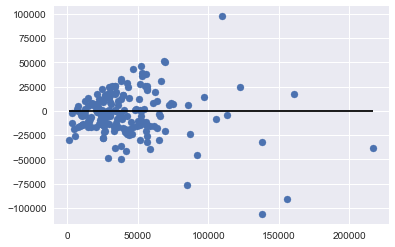

In [123]:
feature_cols = [c for c in dtm.columns if c != 'power' and c != 'Movements' and c != 'Date' and c!= 'Work performed']
X = dtm[feature_cols]
y = dtm['Work performed']

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(Xs, y, random_state=2008)

lr = LinearRegression()
lr.fit(X_train,y_train)


from sklearn.model_selection import cross_val_score

print 'cross_val_score: {}'.format(cross_val_score(lr, X_train, y_train, cv =5).mean())

pred = lr.predict(X_test)

plt.scatter(pred, pred - y_test)
plt.hlines(y = 0, xmin= pred.min(), xmax=pred.max())

from sklearn.metrics import r2_score
print 'R2 score: {}'.format(r2_score(y_test, pred))



Ridge/Lasso/ElasticNet with GridSearch and Standardization

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

In [110]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [114]:
kf = KFold(n_splits=10, shuffle=True, random_state=101)
ridge = Ridge()
r_params = {
    'alpha': np.logspace(-1, 5, 10),
    'solver':  ['auto', 'sag'],
    'fit_intercept' : [True,False]
}

In [115]:
gs = GridSearchCV(ridge, cv=kf, param_grid=r_params, scoring='r2')

In [116]:
gs.fit(Xs,y)
print gs.best_score_
print gs.best_params_

0.577488129116
{'alpha': 46.415888336127772, 'solver': 'auto', 'fit_intercept': True}


In [118]:
lasso = Lasso()
l_params = l_params = {
    'alpha': np.linspace(0,5,20),
    'fit_intercept' : [True,False]
}

In [119]:
gs = GridSearchCV(lasso, cv=kf, param_grid=l_params, scoring='r2')
gs.fit(Xs,y)
print gs.best_score_
print gs.best_params_

C:\Users\p0key\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\p0key\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\p0key\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.576004298062
{'alpha': 5.0, 'fit_intercept': True}


In [121]:
enet = ElasticNet()
en_params = {
    'alpha' : np.linspace(0,5,20),
    'l1_ratio' : np.linspace(0.01,1.0,25)
}

In [122]:
gs = GridSearchCV(enet, cv=kf, param_grid=en_params, scoring='r2')
gs.fit(Xs,y)
print gs.best_score_
print gs.best_params_

0.577623359087
{'alpha': 1.3157894736842104, 'l1_ratio': 0.9587500000000001}


In [124]:
from sklearn.kernel_ridge import KernelRidge

In [125]:
kr = KernelRidge()
kr_params = {
    'alpha': np.logspace(-1, 5, 10)
}

In [126]:
gs = GridSearchCV(kr, cv=kf, param_grid=kr_params, scoring='r2')
gs.fit(Xs,y)
print gs.best_score_
print gs.best_params_

-0.924087290078
{'alpha': 215.44346900318823}


In [129]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [130]:
gb = GradientBoostingRegressor()
rf = RandomForestRegressor()

In [134]:
rf_params = {
    'n_estimators': range(10,30,5),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

In [135]:
gs = GridSearchCV(rf, cv=kf, param_grid=rf_params, scoring='r2')
gs.fit(Xs,y)
print gs.best_score_
print gs.best_params_

0.568585964984
{'max_features': 'auto', 'n_estimators': 20}


In [142]:
gb_params = {
    'n_estimators': [100],
    'loss': ['ls'],
    'max_depth': range(1,11),
    'min_samples_leaf': [1,3,5],
    'max_features' : ['sqrt', 'auto']}

In [143]:
gs = GridSearchCV(gb, cv=kf, param_grid=gb_params, scoring='r2')
gs.fit(Xs,y)
print gs.best_score_
print gs.best_params_

0.622937639555
{'max_features': 'sqrt', 'loss': 'ls', 'n_estimators': 100, 'max_depth': 9, 'min_samples_leaf': 3}
